# Traffic Sign Recognition

_Ahmed Ben Saad, Taha Helal, Yacine Ben Baccar_

<img src="img/first.jpg" height = "60%" width = "60%">

## Introduction

<b>Traffic sings</b> are substantial part of our roads and organize heavily the way we drive cars and as a human, among the things you need to perfectly master to aquire a driving liscence is traffic sign recognition and the behaviour required when each sign is seen.

As a set of recommendations/obligations that tells us how we should drive (or stop) in different road conditions (crossroads, lack of visibility, 1 way roads, priorities to pass,..), they helped us limit the number of car accidents and regulate traffic in all possible situations.

As reported in the findings of an eight-year study conducted by the American National Highway Traffic Safety Administration (NHTSA), there were on average <b>1,578 fatalities </b> each year resulting from two-vehicle traffic crashes at intersections controlled by traffic signals. Approximately <b>51%</b> of those fatal crashes were caused by drivers who ran red lights. Approximately <b> 29% </b> were caused by drivers who failed to yield the right-of-way at traffic signals.

Now that autonomous cars are beginning to hit the road. The question of responsabilty in car crashes rose and became controversial. Many talked about a future where all cars will be 'level 5' autonomous cars. Meaning that they can drive in complete autonomy and communicate with other nearby autonomous cars on the road in order to get the needed informations to decide how to drive. But until then, they will be on the same road as other cars and so their need for traffic signs is as important as humans' and their decisions will remain based on what they see on these signs.


The prediction will so be a part of <b>a fully automated system</b> -The autonomous car- and needs to be retrained for each country as some traffic signs varies between countries.

### Purpose and Data

We want to train a classifier that, given a traffic sign image, predicts its signification. For this, we use the German Traffic Sign Recognition Benchmark Dataset. It is a full dataset of nearly 500Mb of PPM images of varying shapes (from 15x15 to 250x250) to containing 43 different traffic signs types with 39209 train images and 12630 test images. The training set in split in folder with one class images and annotations per folder. To make it more simple we combined the training annotations into a single file Train.csv. The test images are put in one folder and are not part of the training dataset.

<img src="img/second.png" height = "60%" width = "60%">
$$Examples~of~reshaped~dataset~images$$

## Preprocessing

### Generate annotations

The annotations provided in this dataset is a csv file (per class for training set) containing the filename, bounding box coordiantes (which we won't use). So first of all we wanted to regroup all of this into 2 annotations files Train.csv and Test.csv. We also modified the filename to include absolute path for easier acces to images. The code used for this task is annotations_gen.py.

In [ ]:
# %load annotations_gen.py
import os
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



columns = ['Filename', 'ClassId']
#Combine all train annotations into one table 
def load_annotations(data_dir):

    
    annotations = pd.DataFrame(columns = columns)


    annotations_path = os.path.join(data_dir, 'data/Train')

    #iterate over all classes folders to get the class annotations
    for dir_ in os.listdir(annotations_path):
        if dir_.startswith('.'):
           continue

        path = os.path.join(annotations_path, dir_, 'GT-' + dir_+ '.csv')
        annot_dir = pd.read_csv(path, sep=';', usecols=columns)
        annot_dir['Filename'] = annot_dir['Filename'].apply(lambda path : annotations_path+'/'+dir_+'/'+path)
        annotations = pd.concat([annotations, annot_dir], axis = 0)

    return shuffle(annotations)


#Select Filename (entire paths) and ClassId
def test_ann(path_csv):
    filename = 'GT-final_test.csv'
    ann = pd.read_csv(os.path.join(path_csv,filename), sep =';', usecols=columns)
    ann['Filename'] = ann['Filename'].apply(lambda img : path_csv+'/'+img)
    return ann
    
def main():
    #create the whole data annotations file
    # We will save the test csv in the same 
    train_annotations = load_annotations('.')
    test_annotations = test_ann('./data/Test')
    print(test_annotations.head())
    print(train_annotations.head())
    # write csv
    train_annotations.to_csv('./data/Train.csv')
    test_annotations.to_csv('./data/Test.csv')
    print('Annotations generated ! ')

if __name__=='__main__':
    main()

### Data Augmentation

We did some basic data augmentation for model training when defining the train data generator (see below)

### Required dependencies and downloads

#### Installation of libraries and `ramp-workflow`

To get this notebook running and test your models locally using the `ramp_test_submission`, we recommend that you use the Python distribution from [Anaconda](https://www.anaconda.com/download/) or [Miniconda](https://conda.io/miniconda.html). 

In [1]:
# !conda env create -f environment.yml   # use the environment.yml file to create the 'mars-craters' env
# !source activate Traffic          # activate the virtual environment

**OR** if you have Python already installed but are **not using Anaconda**, you'll want to use `pip` 

In [2]:
# !pip install -r requirements.txt

If you encoutner a problem with the Train.csv and Test.csv file uncomment the next cell to recreate them :

In [3]:
# !python annotations.py

### The input data

In [12]:
from annotations_gen import *

In [5]:
train_annotations = load_annotations('.')
train_annotations.head()

X = train_annotations['Filename']
Y = train_annotations['ClassId']

Let us display some images

In [38]:
import matplotlib.pyplot as plt
import cv2

In [21]:
idx_display = [30, 320, 7030]

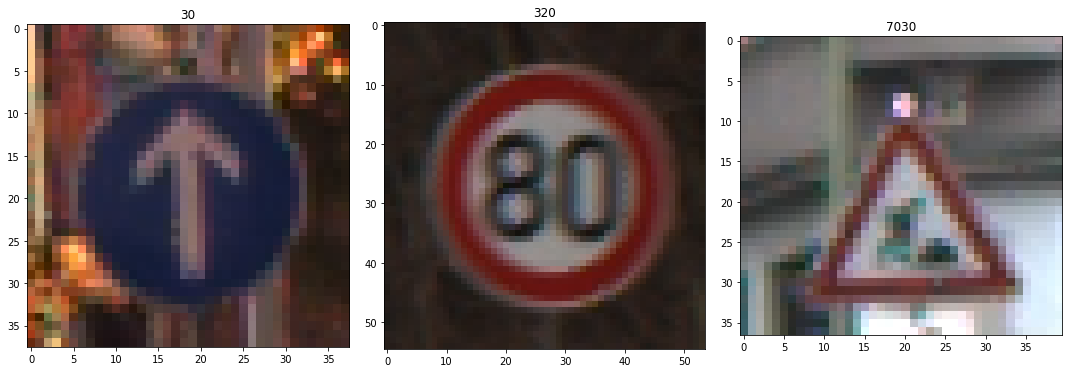

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, idx in enumerate(idx_display):
    img = cv2.imread(X[idx])
    #to read with opencv and plot with plt, we need to switch color channels
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    axes[i].imshow(img)
    axes[i].set_title('%d' % idx)
fig.tight_layout()

In [23]:
Y.head()

0    10
1     0
2    38
3    14
4    36
Name: ClassId, dtype: object

In [ ]:
#number of images per class
Y.nuniques()

The labels are indexes corresponding to each traffic sign, we provide a list of the labels per index here (it was not given with the dataset) :

In [34]:
L = ['Speed limit : 20', 'Speed limit : 30', 'Speed limit : 50', 'Speed limit : 60', 'Speed limit : 70', 
     'Speed limit : 80', 'End of speed limit : 80', 'Speed limit : 100', 'Speed limit : 120', 'No overtaking',
     'No overtaking for trucks', 'Crossroads', 'Priority', 'Yield', 'Stop', 'Speed limit : Blank', 'No truck',
     'No entry', 'Warning', 'Bend to left', 'Bend to right', 'Double bend, first to the left', 'Uneven road',
     'Slippery road', 'Road narrows on right', 'Men at work', 'Traffic lights', 'Warning pedestrians',
     'Warning children', 'Cycle route ahead', 'Risk of ice', 'Warning wild animals', 'End of all restrictions',
     'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Mandatory turn right and straight ahead',
     'Mandatory turn left and straight ahead', 'Keep right', 'Keep left', 'Mini-roundabout', 'End of no overtaking', 
     'End of no overtaking for trucks']

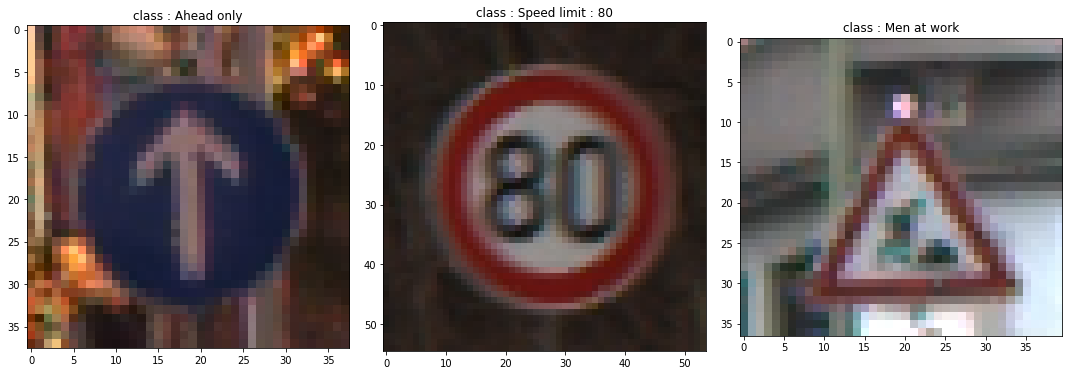

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
for i, idx in enumerate(idx_display):
    img = X[idx]
    lab = Y[idx]
    img_raw = cv2.imread(img)
    b,g,r = cv2.split(img_raw)
    img_raw = cv2.merge([r,g,b])
    axes[i].imshow(img_raw)
    axes[i].set_title('class : %s' % L[lab])
fig.tight_layout()

### Other comments about Data

The various shape of train images can make the classifier robust to image quality 
 <br>Color can be a good feature in classification so we chose to keep data in 3 channels instead of giving grayscale images

### Metrics

This is a multi-class classification problem. We have many metrics for this kind of problem but we chose the following
#### Accuracy

Accuracy is the fraction of correct predictions. As the dataset is not heavily unbalanced, it can be used a metric to evaluate the model robustness. For our problem, we need a very high accuracy because an autonomous car should predict the correct sign to behave correctly on the road

$$accuracy~=~\frac{nb~of~correct~predictions}{nb~of~predictions} $$

#### Negative Log Loss

Negative log loss is also an important metric for our problem. A model with high NLL is a model who predicts wrong classes with high probability

$$NLL~=~-\frac{1}{N}\Sigma^{N}_{i=1}\Sigma^{M}_{j=1}log(p_{ij}) $$

#### Macro averaged precision / recall

Macro averaged precision/recall is the average of precision/recall over all classes, we need to be sure that the model is good in predicting all classes. Remember that :
$$precision~=~\frac{TP}{TP + FP} \\$$
$$recall~=~\frac{TP}{TP + FN}$$


#### F1 score

It is difficult to find an intuitive interpretation of F1 score. It is the harmonic average of precision and recall. We added F1 score at 0.7 and at 0.8 to assure additional metrics for better candidate separation

## Technical part

### The model 

Convolutional Neural Netwroks have proven their efficiency in such image classification task. Many State Of The Art techniques in classification/detection include using CNNs. So we decided to create a CNN as follows : 
<ul>
<li> 1 3 filter Conv Layer with 1x1 kernel size to extract information from colors. Followed by 0.3 Dropout layer to avoid overfitting (the Dropout layers are placed after each Convolutional layer, as for Batch Normalization to improve accuracy). </li>
<li>1 64 filter Conv Layer with 5x5 kernel size</li>
<li>1 Max Pooling Layer with pool size 2x2 with 2x2 strides (to accelerate training process)</li>
<li>1 80 filter Conv Layer with 3x3 kernel size</li>
<li>1 Max Pooling Layer with pool size 2x2 with 2x2 strides</li>
<li>1 100 filter Conv Layer with 3x3 kernel size</li>
<li>1 Max Pooling Layer with pool size 2x2 with 2x2 strides</li>
<li>1 150 filter Conv Layer with 3x3 kernel size</li>
<li>1 Max Pooling Layer with pool size 2x2 with 2x2 strides</li>
<li> 2 Dense layers with 100 cells </li>
<li> 1 Dense layer with 43 cells as classification layer </li>

we also used relu activation for all layers except the last one (softmax for probability like output) and Stochastic Gradient Descent as optimizer due to the simplicity of the created model

In [2]:
import os
import pandas as pd
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dense,Dropout, Flatten, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, SGD
import functools
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, Callback, LearningRateScheduler
import cv2
import math
from keras.models import load_model

Using TensorFlow backend.


In [28]:
def create_model(input_size = (128,128,3), epochs = 100 , lr = 1e-3 ):
    model = Sequential()
    model.add(Conv2D(3, input_shape= input_size, kernel_size=1, padding="same", activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(64, kernel_size=5, padding="same", activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(80, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(100, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(150, kernel_size=3, padding="valid", activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0,5))
    
    model.add(Dense(43, activation='softmax'))
#    opt = Adam(lr=0.0001, amsgrad=True)
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)


    model.compile(loss='categorical_crossentropy',optimizer = sgd, metrics=['accuracy'])
    

    
    return model

In [29]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 3)       12        
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      4864      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 64)        0         
__________

### Data Augmentation

One of the best ways to improve the performance of a Deep Learning model is to add more data to the training set. That's why we opted for data augmentation as follows : <br>
<ul>
<li>For each iteration, we select batch_size / 8 images from training dataset</li>
<li>For each image, we generate other input images by applying random translation, rotation, shear and randomly modifying the brightness</li>
<li>We add generated images to the batch and we feed the batch to the network</li>
</ul>

In [35]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range = 35,
                     shear_range=10,trans_range = 10):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    
    # Brightness 
    

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    img = augment_brightness_camera_images(img)
    
    return img


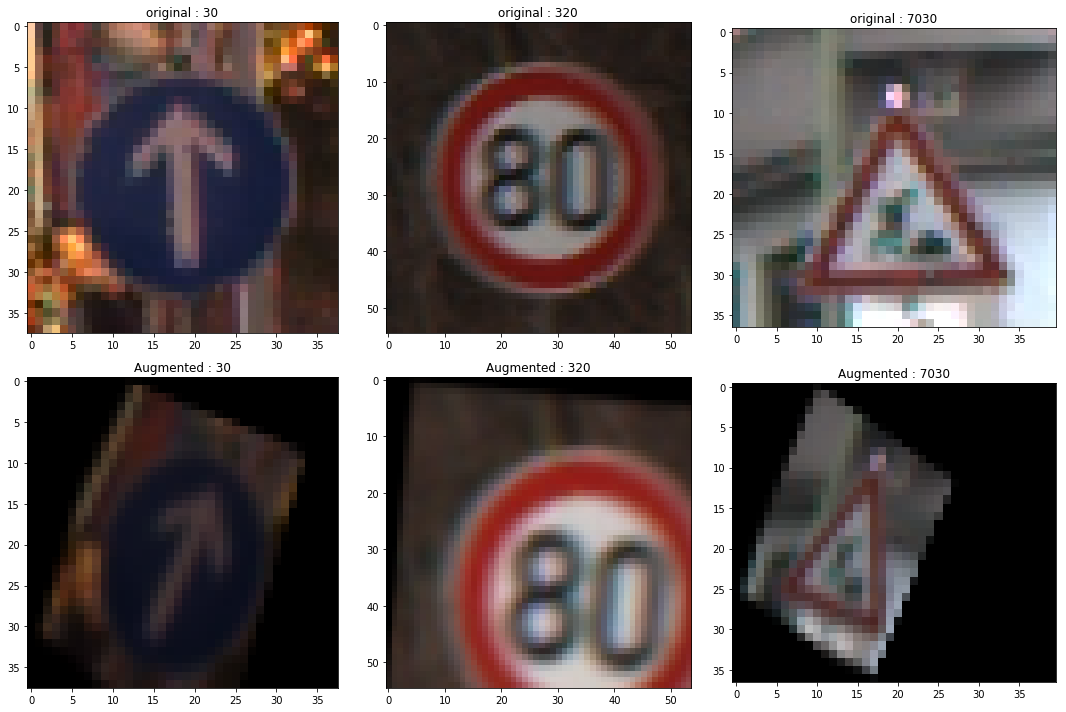

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, idx in enumerate(idx_display):
    img = X[idx]
    lab = Y[idx]
    img_raw = cv2.imread(img)
    b,g,r = cv2.split(img_raw)
    img_raw = cv2.merge([r,g,b])
    axes[0,i].imshow(img_raw)
    axes[0,i].set_title('original : %d' % idx)
    axes[1,i].imshow(transform_image(img_raw))
    axes[1,i].set_title('Augmented : %d' % idx)

fig.tight_layout()

### Data Generators

We used Data generators to feed data for our CNN. We used 2 generators, one for train and one for validation. It's the same thing except that we added random data augmentation in the train generator

In [37]:
def train_generator(anns_x, anns_y, batch_size = 64, target_size = (128,128), classes = 43):
    n_samples = anns_x.shape[0]
    while True:
        original_batch_size = batch_size // 8
        for i in range(0, n_samples, original_batch_size):
            imgs = [cv2.imread(file) for file in anns_x.iloc[i:i+(original_batch_size)]]
            imgs_resized = [cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR) for img in imgs]
            X_batch = [img for img in imgs_resized]
            Y_batch = list(anns_y.iloc[i:i+original_batch_size])

            #Data Augmentation : we will generate 8 images for each existing image
            for j in range(len(X_batch)):
                for _ in range(8):
                    X_batch.append(transform_image(X_batch[j]))
                    Y_batch.append(Y_batch[j])
            yield np.array(X_batch), to_categorical(np.array(Y_batch),num_classes=43)


def valtest_generator(anns_x, anns_y, batch_size = 100, target_size = (128,128), classes = 43):
  n_samples = anns_x.shape[0]
  while True:

      for i in range(0, n_samples, batch_size):
          imgs = [cv2.imread(file) for file in anns_x.iloc[i:i+batch_size]]
          imgs_resized = [cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR) for img in imgs]
          X_batch = [img for img in imgs_resized]
          Y_batch = anns_y.iloc[i:i+batch_size]
          yield np.array(X_batch), to_categorical(np.array(Y_batch),num_classes=43)

### Training 

We provide hier code for training. We highly recommand using a GPU for training to achieve acceptable results in an acceptable time. Skip these cells if you want to directly import the trained model


In [38]:
# Some Callbacks
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.5
   epochs_drop = 20.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))


In [40]:
#split data into train and test
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.2)


loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)

callbacks_list = []
callbacks_list.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=5, epsilon=0.001,
                                   cooldown=2, verbose=1))

history = model.fit_generator(train_generator(X_train ,y_train,batch_size),
                steps_per_epoch=5 * X_train.shape[0] / batch_size, epochs = 100,
                validation_data =valtest_generator(X_val ,y_val,batch_size),
                 validation_steps = X_val.shape[0]/batch_size,
                 callbacks = callbacks_list )

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Uncomment this line if you want to directly load the model

In [53]:
model = load_model('trained_1.h5')

### Testing

In [5]:
from rampwf.score_types.classifier_base import ClassifierBaseScoreType

#We define macro averaged precision as it is not implemented in rampwf
class MacroAveragedPrecision(ClassifierBaseScoreType):
    is_lower_the_better = False
    minimum = 0.0
    maximum = 1.0

    def __init__(self, name='accuracy', precision=4):
        self.name = name
        self.precision = precision

    def __call__(self, y_true_label_index, y_pred_label_index):
        score = precision_score(
            y_true_label_index, y_pred_label_index, average='macro')
        return score

In [6]:
from rampwf.score_types import Accuracy, NegativeLogLikelihood, MacroAveragedRecall

In [13]:
test_anns = test_ann('./data/Test')

# load test data (because it's not done yet)
X_test = test_anns['Filename']
Y_test = test_anns['ClassId']
imgs = [cv2.imread(path) for path in X_test]
imgs_resized = [cv2.resize(img, (128,128), interpolation=cv2.INTER_LINEAR) for img in imgs]
Y_pred = model.predict_classes(np.array(imgs_resized))
Y_pred_proba = model.predict(np.array(imgs_resized))

TypeError: %d format: a number is required, not Accuracy

In [21]:
from sklearn.metrics import precision_score


nll = NegativeLogLikelihood()
mar  = MacroAveragedRecall()
map_ = MacroAveragedPrecision()
acc = Accuracy()
print('Test acc : %f' % acc(Y_pred, Y_test))
print('*'*20)
print('Test NegativeLogLikelihood : %f' % nll(Y_pred, Y_test))
print('*'*20)
print('Test MacroAveragedRecall : %f' % mar(Y_pred, Y_test))
print('*'*20)
print('Test MacroAveragedPrecision : %f' % map_(Y_pred, Y_test))
print('*'*20)


Test acc : 0.867142
********************
********************
Test MacroAveragedRecall : 0.849010
********************
Test MacroAveragedPrecision : 0.777715
********************
Test F1_70 : 0.813953
********************
Test F1_80 : 0.697674
********************


/home/ahmed/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ahmed/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Some predictions on images found on Google : One good and one bad

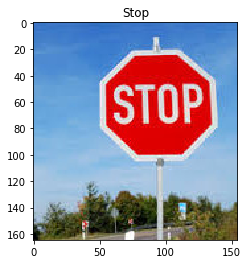

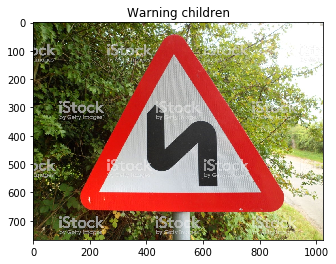

In [67]:
path = './img/predictions/'
predictions = []
for img in os.listdir(path):
    plt.figure()
    img_raw = cv2.imread(path+img)
    img_raw_resized = cv2.resize(img_raw,(128,128))
    pred = model.predict_classes(np.expand_dims(img_raw_resized,0))[0]
    plt.title(L[pred])
    b,g,r = cv2.split(img_raw)
    img_raw = cv2.merge([r,g,b])
    plt.imshow(img_raw)


### The pipeline

For submitting at the [RAMP site](http://ramp.studio), we integrated our model in RAMP workflow by creating a file named classifier.py

In [ ]:
# %load submissions/main/classifier.py
import numpy as np 
from sklearn.base import BaseEstimator
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dense,Dropout, Flatten,BatchNormalization
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import functools
import tensorflow as tf
import cv2 


class Classifier(BaseEstimator):
    def __init__(self, n_epochs = 15, batch_size = 80, lr = 1e-3):
        self.epochs = n_epochs
        self.batch_size = batch_size
        self.lr = lr
        
        self.model = create_model()

    def fit(self, X, y):

        X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)
        ntrain_samples = X_train.shape[0]
        nval_samples = X_val.shape[0]
        validation_steps = nval_samples / self.batch_size 
        steps_per_epoch = ntrain_samples / self.batch_size
        validation_steps = nval_samples / self.batch_size

        self.model.fit_generator(data_generator(X_train ,y_train,self.batch_size),
                                steps_per_epoch=steps_per_epoch, epochs = self.epochs, 
                                validation_data =data_generator(X_val ,y_val,self.batch_size),
                                 validation_steps = validation_steps )

        

    def predict(self, X):
        imgs = [cv2.imread(path) for path in X]
        imgs_resized = [cv2.resize(img, (128,128), interpolation=cv2.INTER_LINEAR) for img in imgs]
        return self.model.predict_classes(np.array(imgs_resized))

    def predict_proba(self, X):
        imgs = np.array([cv2.imread(path) for path in X])
        imgs_resized = [cv2.resize(img, (128,128), interpolation=cv2.INTER_LINEAR) for img in imgs]
        print(len(imgs_resized))
        return self.model.predict(np.array(imgs_resized))

# Defining model

def create_model(input_size = (128,128,3), epochs = 10 , lr = 1e-3 ):
    model = Sequential()
    model.add(Conv2D(64, input_shape= input_size, kernel_size=5, padding="same", activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Conv2D(80, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Conv2D(100, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Conv2D(150, kernel_size=3, padding="valid", activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(43, activation='softmax'))
    decay_rate = lr / epochs
    opt = Adam(lr=0.001, decay=decay_rate, amsgrad=True)
    model.compile(loss='categorical_crossentropy',optimizer = opt, metrics=['accuracy'])
    return model

# Data Generator
def data_generator(anns_x, anns_y, batch_size = 100, target_size = (128,128), classes = 43):
    n_samples = anns_x.shape[0]
    while True:

        for i in range(0, n_samples, batch_size):
            imgs = [cv2.imread(file) for file in anns_x.iloc[i:i+batch_size]]
            imgs_resized = [cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR) for img in imgs]
            X_batch = [img for img in imgs_resized]
            Y_batch = anns_y.iloc[i:i+batch_size]
            yield np.array(X_batch), to_categorical(np.array(Y_batch),num_classes=43)


## Local testing/exploration

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/main), not on the classes defined in the cells of this notebook.

Check list

- Make sure you have installed `ramp-workflow` locally (see [above](#Installation-of-ramp-workflow))
- Make sure that the python files `classifier.py` is in the  `submissions/your_submission` folder.

Finally, make sure the local processing goes through by running the

```
ramp_test_submission --submission your_submission
```

If you want to quickly test the that there are no obvious code errors, use the `--quick-test` keyword to only use data from the first 30 images. 

```
ramp_test_submission --submission your_submission --quick-test
```

In [103]:
!ramp_test_submission --quick-test

Testing Mars craters detection and classification
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
Couldn't re-order the score matrix..
	score   ap  madc  madr   ospa  ...    rec(0)  rec(0.5)  rec(0.9)    scp
	step                           ...                                     
	test   0.0   NaN   NaN  0.989  ...     0.514       0.0       0.0  0.991
	train  0.0   NaN   NaN  0.995  ...     0.647       0.0       0.0  0.995
	valid  0.0   NaN   NaN  0.991  ...     0.714       0.0       0.0  0.994
CV fold 1
Couldn't re-order the score matrix..
	score   ap  madc  madr   ospa  ...    rec(0)  rec(0.5)  rec(0.9)    scp
	step                           ...                                     
	test   0.0   NaN   NaN  0.989  ...     0.514       0.0       0.0  0.991
	train  0.0   NaN   NaN  0.994  ...     0.786       0.0       0.0  0.995
	valid  0.0   NaN   NaN  0.992  ...     0.500       0.0       0.0  0.993
CV fold 2
Couldn't re-orde